In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import os
import re
import sys
import scipy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
import numpy as np

from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive/')
#TODO
# fix -- change to scare quotes folder
%cd /content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Scare Quotes/1_Data Prep
%ls


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/gdrive/
/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Scare Quotes/1_Data Prep
 quoted_dataframe_annotate.csv
 quoted_dataframe_annotate.xlsx
 scare_quote_data_prep.ipynb
'Sentiment Score Distribution of Sentences with matching quotations.png'
'Sentiment Score Distribution of Sentences with Quote and Patient Regex Matching.png'


BigQuery

In [ ]:
#Replace 'project_id' with your BigQuery project ID

from google.cloud import bigquery
client = bigquery.Client(project='detecting-bias-mimic-iii')

icd_query = ('''SELECT *
                FROM physionet-data.mimiciii_clinical.diagnoses_icd
                LIMIT 1000''')

icd = client.query(icd_query).to_dataframe()



ICD codes

In [ ]:


#Filter for ICD codes for 282.60-282.69, referring to sickle cell types w/wo crisis
#2824 for thalassemia w + w/o crisis (282.41-282.42)
#SCD: 2826,2824
#Chronic Pain 3382
#Opioid dependencies: 3040,3047 (combo),
#HIV/AIDS ^042$

icds_of_interest = icd[icd['ICD9_CODE'].str.contains('2826|2824|3040|3047|3382|^042$', na=False)]
# Issues here-- will cause more leading numbers
print(icds_of_interest.head())

icds_of_interest.info()

#patients_unique = icds_of_interest['SUBJECT_ID'].drop_duplicates()


Notes and patients load

In [ ]:
note_query = ('''SELECT *
                FROM physionet-data.mimiciii_notes.noteevents
                LIMIT 50000''')

NOTES = client.query(note_query).to_dataframe()

peek_notes = NOTES.head()
print(peek_notes)

## Patients

patient_query = ('''SELECT *
                FROM physionet-data.mimiciii_clinical.patients''')

PATIENTS = client.query(patient_query).to_dataframe()

peek_patients = PATIENTS.head()
print(peek_patients)

biased_notes_patients_corpus = NOTES.merge(PATIENTS, on = 'SUBJECT_ID')

biased_notes_patients_corpus.info()
# Find unique chart types and decide to limit them
    # Remove Radiology, ECG, Respiratory, Echo notes
biased_notes_patients_corpus_filtered = biased_notes_patients_corpus[biased_notes_patients_corpus["CATEGORY"].str.contains("Radiology|ECG|Respiratory|Echo")==False]
# biased_notes_patients_corpus_filtered.to_csv("biased_notes_patients_corpus_filtered.csv")



Explode by sentence, regex quote match

In [ ]:
full_dataframe = biased_notes_patients_corpus_filtered
# Tokenize by sentence
nlp = English()  # just the language with no model

nlp.add_pipe('sentencizer')
full_dataframe["Sentence"] = full_dataframe["TEXT"].apply(lambda x: [sent.text for sent in nlp(x).sents])
full_dataframe = full_dataframe.explode("Sentence", ignore_index=True)
full_dataframe.rename(columns={"Unnamed: 0": "ROW_ID_new"}, inplace=True)
full_dataframe.index.name = "Sentence ID"

full_dataframe['Sentence'].replace(r'\s+|\\n', ' ', regex=True, inplace=True)




In [ ]:
# Read in tokenized data frame
full_dataframe = pd.read_csv("/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/mimic_iii_sentence_tokenized.csv")



<ipython-input-2-eb19bb3fafe2>:2: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dataframe = pd.read_csv("/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/mimic_iii_sentence_tokenized.csv")


In [ ]:
small_dataframe = full_dataframe.head(100000)

def check_text(text):
    pattern = r'(?=.*\".*\")(?=.*\b(pt|patient|pateint|he|she|they)\b)'
    return bool(re.search(pattern, text, re.IGNORECASE))

# Test
print(check_text('This is a "test" string with patient'))  # True
print(check_text('This is a "test" string without any term'))  # False
print(check_text('This is a test string with pt but without quotes'))  # False


regex = r'(?=.*\".*\")(?=.*\b(pt|patient|pateint)\b)'
quotes = r'"(.*?)"'
quote_only = full_dataframe.loc[full_dataframe['Sentence'].str.contains(quotes)]
print(f"Sentences of only double-quote matches: {quote_only.shape[0]}")  # Print the size before filter



# Add & needs to include patient | pt , lowercase match
quoted_dataframe = full_dataframe.loc[full_dataframe['Sentence'].str.contains(regex)]
quoted_dataframe['quoted_text'] = full_dataframe['Sentence'].str.extract(quotes)
print(f"Sentences of double-quote and patient matches: {quoted_dataframe.shape[0]}")  # Print the size after filter


quoted_dataframe
quoted_dataframe["scare_quote"] = ""
quoted_dataframe["annotator_comments"] = ""
# 3842 quoted charts sentences total of 1,510,650 sentences
quoted_dataframe2 = quoted_dataframe.drop_duplicates(subset=['Sentence'])
quoted_dataframe2.to_excel("quoted_dataframe_annotate.xlsx", index = False)



True
False
False


<ipython-input-3-3d9e11958d25>:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  quote_only = full_dataframe.loc[full_dataframe['Sentence'].str.contains(quotes)]


Sentences of only double-quote matches: 42999


<ipython-input-3-3d9e11958d25>:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  quoted_dataframe = full_dataframe.loc[full_dataframe['Sentence'].str.contains(regex)]
<ipython-input-3-3d9e11958d25>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quoted_dataframe['quoted_text'] = full_dataframe['Sentence'].str.extract(quotes)
<ipython-input-3-3d9e11958d25>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quoted_datafr

Sentences of double-quote and patient matches: 6814


# Sample the annotation dataframe

In [ ]:
quoted_dataframe2 = pd.read_csv("quoted_dataframe_annotate.csv")


In [ ]:

quoted_dataframe2
print("Length of original dataframe: ", len(quoted_dataframe2))

# Remove common AOx4 Questions and sounds, or signifiying Do Not Rescuscitate/comfort measures taken
words = ['yes','no','itchy','hospital','Do Not Resuscitate', 'Yes or No', 'wet','yes/no','dry','DO NOT RESUSCITATE','comfort measures only', 'Known', 'Name', 'firstname', 'lastname','[**Doctor Last Name **]', '[**Last Name (un) **]', '[**Known firstname **] [**Known lastname **]','[**Doctor First Name **]', '[**Hospital1 **]','[**Hospital3 **]','[**Known lastname **], [**Known firstname **]']
# dramatic, unreliable, entitled, invalid, violent, dangerous
# Trim leading and trailing whitespaces
quoted_dataframe2['quoted_text'] = quoted_dataframe2['quoted_text'].str.strip()

# Filter the dataframe of the words which were found to have high amount of noise
quoted_dataframe_pruned = quoted_dataframe2[~quoted_dataframe2['quoted_text'].isin(words)]
print("Length of pruned dataframe: ", len(quoted_dataframe_pruned))


np.random.seed(23)
# List of tuples (sample size, dataframe name)
sample_params = [(50, 'Drew_initial'), (5, 'cocode'), (100, 'reliability'), (400, 'annotation_Annie'), (500, 'annotation_Drew')]

# Dictionary to hold the dataframes
dfs = {}

for size, name in sample_params:
    # Random sample without replacement
    sample_df = quoted_dataframe_pruned.sample(n=size, replace=False)

    # Add the sample to the dictionary
    dfs[name] = sample_df

    # Remove the sampled rows from the original dataframe
    quoted_dataframe_pruned = quoted_dataframe_pruned.drop(sample_df.index)

%cd /content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Scare Quotes/2_Annotation

# Now you can access each dataframe using their names.
# For example, to access the 'Drew' dataframe:
drew_df = dfs['Drew_initial']
drew_df
drew_df.to_excel("Drew_initial_sample_scare_quotes.xlsx", index=False)

cocode_df = dfs['cocode']
cocode_df
cocode_df.to_excel("cocode_sample_scare_quotes.xlsx", index=False)

reliability_df = dfs['reliability']
reliability_df
reliability_df.to_excel("reliability_sample_scare_quotes_Annie.xlsx", index = False)
reliability_df.to_excel("reliability_sample_scare_quotes_Drew.xlsx", index = False)

annotation_Annie_df = dfs['annotation_Annie']
annotation_Annie_df
annotation_Annie_df.to_excel("annotation_Annie_sample_scare_quotes.xlsx", index = False)

annotation_Drew_df = dfs['annotation_Drew']
annotation_Drew_df
annotation_Drew_df.to_excel("annotation_Drew_sample_scare_quotes.xlsx", index = False)

quoted_dataframe_pruned

Length of original dataframe:  5156
Length of pruned dataframe:  4737


Explore the Data


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-7-24ec339c5cac>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quoted_dataframe_pruned['Tokenized'] = quoted_dataframe_pruned['quoted_text'].apply(preprocess)


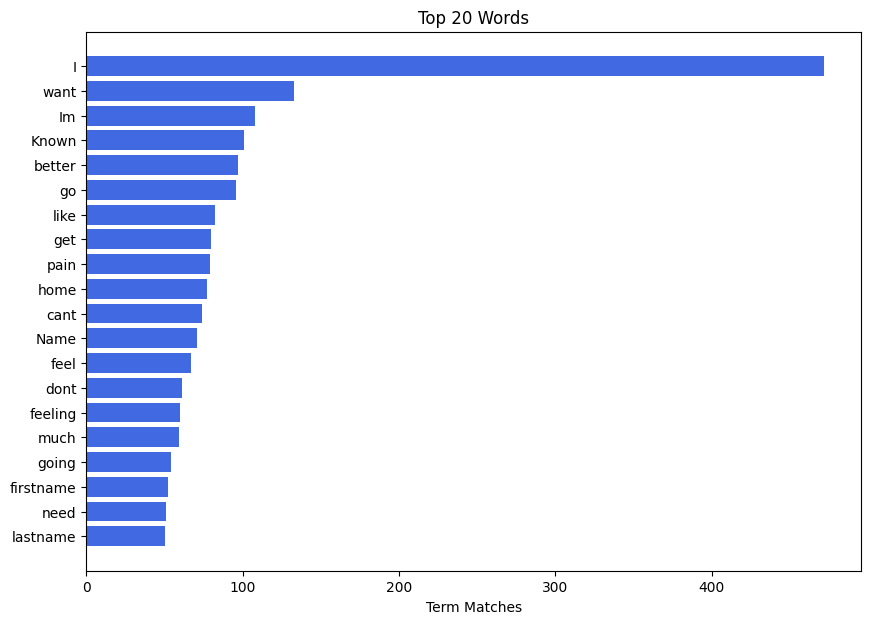

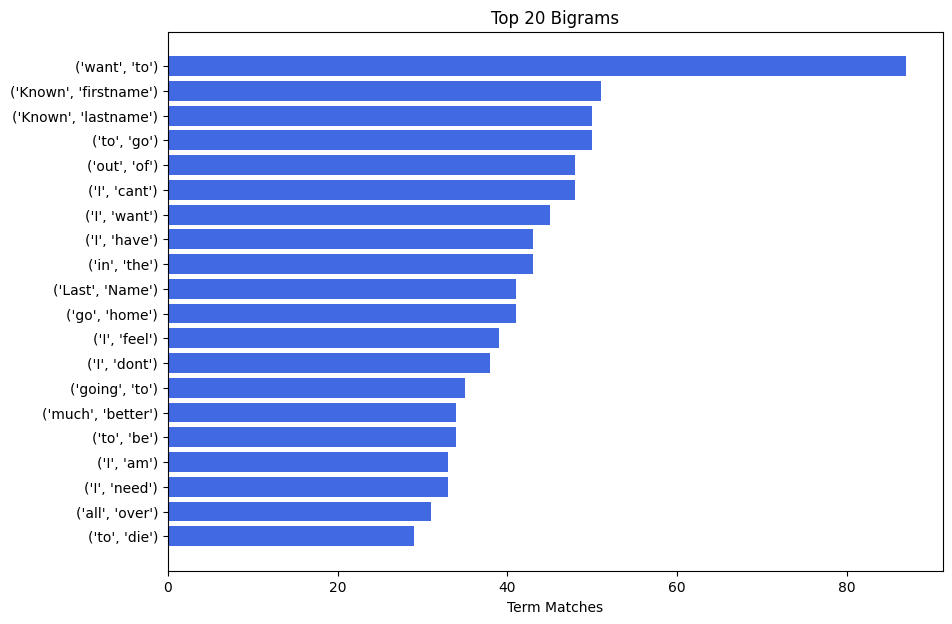

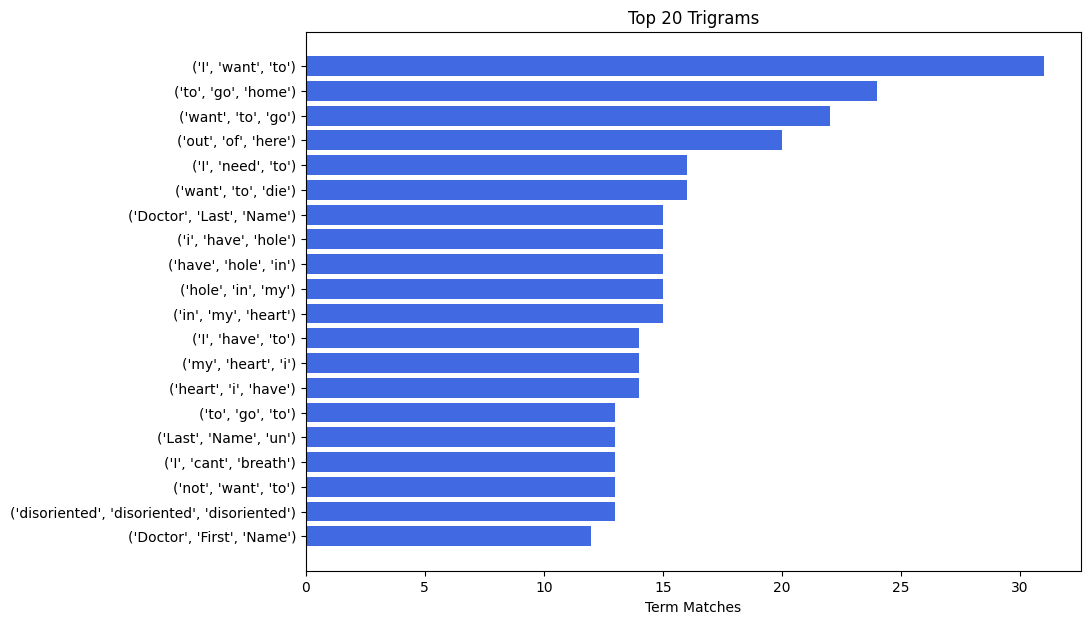

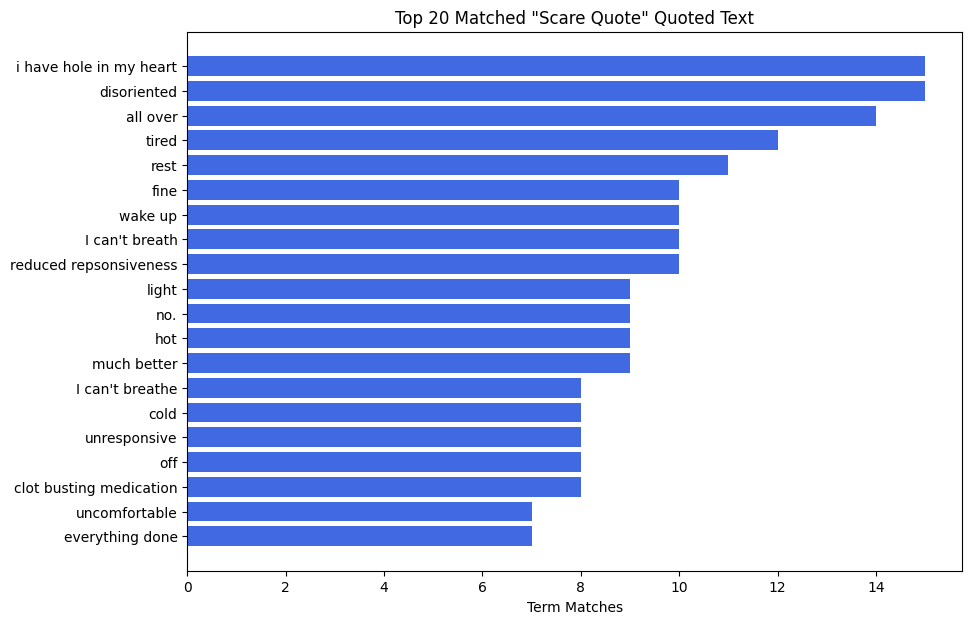

In [ ]:
import pandas as pd
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string

# Load the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to remove punctuation and tokenize
def preprocess(sentence):
    # Remove punctuation
    sentence = str(sentence).translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = nltk.word_tokenize(sentence)
    return tokens

# Apply preprocessing and tokenization
quoted_dataframe_pruned['Tokenized'] = quoted_dataframe_pruned['quoted_text'].apply(preprocess)

# Flatten the list of words in Tokenized column
words = [word for sublist in quoted_dataframe_pruned['Tokenized'].tolist() for word in sublist]

# Remove stopwords
filtered_words = [word for word in words if word not in stop_words]

# Generate bigrams and trigrams
bigram_list = list(bigrams(words))
trigram_list = list(trigrams(words))

# Get the frequency of each word, bigram, and trigram
filtered_word_freq = Counter(filtered_words)
bigram_freq = Counter(bigram_list)
trigram_freq = Counter(trigram_list)

# Get top 20 most common words, bigrams, and trigrams
top20_filtered_words = filtered_word_freq.most_common(20)
top20_bigrams = bigram_freq.most_common(20)
top20_trigrams = trigram_freq.most_common(20)

# Function to create horizontal bar chart
def plot_most_common(n_most_common, title):
    items, counts = zip(*n_most_common)
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(items)), counts, color='royalblue')  # Changed color to royal blue
    plt.yticks(range(len(items)), items)
    plt.xlabel("Term Matches")  # Adding x-axis label
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
    plt.show()


# Plot top 20 most common words, bigrams, and trigrams
plot_most_common(top20_filtered_words, 'Top 20 Words')
plot_most_common(top20_bigrams, 'Top 20 Bigrams')
plot_most_common(top20_trigrams, 'Top 20 Trigrams')

# Get the frequency of each matched full quote
matched_term_freq = Counter(quoted_dataframe_pruned['quoted_text'])

# Get top  most common matched terms
top_matched_terms = matched_term_freq.most_common(20)
top_matched_terms
# '[**Hospital3 **]','[**Known lastname **], [**Known firstname **]'
# Plot top  most common matched terms
plot_most_common(top_matched_terms, 'Top 20 Quoted Texts in "Scare Quotes" Dataset')


# Token Lengths

In [ ]:

#Define a function to count words in a sentence
def word_count(sentence):
    return len(sentence.split())

# Calculate word count for each row of the 'Sentence' and 'TEXT' columns
quoted_dataframe2['Sentence_word_count'] = quoted_dataframe2['Sentence'].apply(word_count)
quoted_dataframe2['TEXT_word_count'] = quoted_dataframe2['TEXT'].apply(word_count)

# Calculate the mean, median, and standard deviation of word counts
sentence_mean = quoted_dataframe2['Sentence_word_count'].mean()
sentence_median = quoted_dataframe2['Sentence_word_count'].median()
sentence_std = quoted_dataframe2['Sentence_word_count'].std()

text_mean = quoted_dataframe2['TEXT_word_count'].mean()
text_median = quoted_dataframe2['TEXT_word_count'].median()
text_std = quoted_dataframe2['TEXT_word_count'].std()

print("Sentence word count - Mean: {}, Median: {}, Std: {}".format(sentence_mean, sentence_median, sentence_std))
print("Each Narrative entry word count - Mean: {}, Median: {}, Std: {}".format(text_mean, text_median, text_std))


Sentence word count - Mean: 54.85899922420481, Median: 24.0, Std: 90.25442482919324
Each Narrative entry word count - Mean: 763.0872769588829, Median: 352.5, Std: 916.441442166676


## All scare quote sentences sentiment

In [ ]:
#!pip install transformers


from transformers import AutoTokenizer, pipeline

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
sentiment_pipeline = pipeline("sentiment-analysis")

def apply_sentiment(sentence):
    # Tokenize the sentence and truncate to 256 tokens
    tokens = tokenizer.tokenize(sentence)[:256]
    # Rejoin the tokens into a truncated sentence
    truncated_sentence = ' '.join(tokens)
    # Apply the sentiment pipeline
    result = sentiment_pipeline(truncated_sentence)[0]
    return result['label'], result['score']
quoted_sentiment = quoted_dataframe2
# Get both the sentiment and score in one apply function
quoted_sentiment['sentiment_result'] = quoted_dataframe2['Sentence'].apply(apply_sentiment)

# Split the result into two separate columns
quoted_dataframe2[['sentiment', 'sentiment_score']] = pd.DataFrame(quoted_dataframe2['sentiment_result'].tolist(), index=quoted_dataframe2.index)

# You can drop the 'sentiment_result' column afterwards if it's not needed
quoted_dataframe2 = quoted_dataframe2.drop(columns=['sentiment_result'])


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors


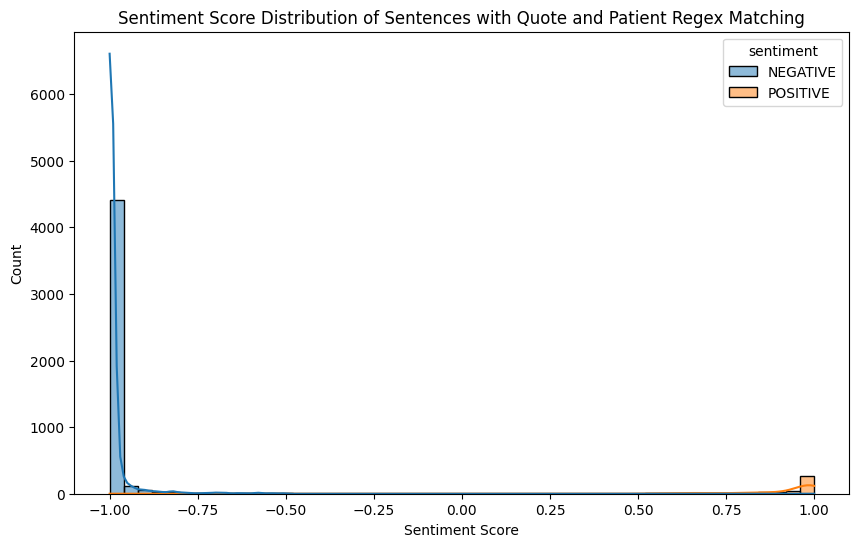

<Figure size 640x480 with 0 Axes>

In [ ]:
quoted_dataframe2['sentiment_score_signed'] = quoted_dataframe2.apply(lambda row: -row['sentiment_score'] if row['sentiment'] == 'NEGATIVE' else row['sentiment_score'], axis=1)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(data=quoted_dataframe2, x="sentiment_score_signed", hue="sentiment", bins=50, kde=True)
plt.title('Sentiment Score Distribution of Sentences with Quote and Patient Regex Matching')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()
plt.savefig("Sentiment Score Distribution of Sentences with Quote and Patient Regex Matching.png", bbox_inches='tight', dpi=300)


## Most positive, negative, and neutral sentences

In [ ]:
# Top 10 positive sentences
top_positive = quoted_dataframe2[quoted_dataframe2['sentiment'] == 'POSITIVE'].nlargest(20, 'sentiment_score_signed')[['Sentence', 'sentiment_score_signed', 'quoted_text']]
print("Top 20 Positive Sentences:")
print(top_positive)

# Top 10 negative sentences
top_negative = quoted_dataframe2[quoted_dataframe2['sentiment'] == 'NEGATIVE'].nsmallest(20, 'sentiment_score_signed')[['Sentence', 'sentiment_score_signed','quoted_text']]
print("\nTop 20 Negative Sentences:")
print(top_negative)

# Top 10 neutral sentences
quoted_dataframe2['abs_sentiment_score'] = quoted_dataframe2['sentiment_score_signed'].abs()
top_neutral = quoted_dataframe2.nsmallest(20, 'abs_sentiment_score')[['Sentence', 'abs_sentiment_score','quoted_text']]
print("\nTop 20 Neutral Sentences:")
print(top_neutral)


Top 20 Positive Sentences:
                                               Sentence  \
2388   Family is very hopeful and says that pt "is a...   
2167  patient also has good concept of time and is a...   
3770   Mo talks about pt as a very "special" and gif...   
4882  Each time pt was asked about her well-being an...   
134    Mother reports that pt is doing "really well"...   
772    Pt's family report pt is a "very bright man w...   
4299            i asked pt-"it's ok for them to do it."   
904   Very hopeful of pt's recovery because their be...   
2316   Sister reports pt is "very outgoing" and has ...   
3248   Overall, the patient reports feeling "good la...   
4516   CCU NPN 1900-0700 S: " I'm feeling good " O: pt.   
2012  Wife stated patient is the "best" he has been ...   
3801   Father states that pt is very smart and talen...   
4283  s: "can i have the phone" o/a: pt alert and or...   
2269   Family was appropriately tearful and expresse...   
113    Currently, the patient